# Cluster Interpretation and Improvement
***

In this module I'll focus on understanding the champion type clusters I previously derived and hopefully improving them. I'll do this through a combination of techniques, including:

- VIF testing to eliminate features providing redundent information (ie infinite VIF values). This will not only improve interpretability but also lower the computational complexity of k-means and t-SNE algorithms.
- t-SNE to reduce the dimensionality of playerDF for each of the player position partitions in order to visually inspect the validity of the initial clusters and determine if 
- A helper function that will tell me which features had the strongest influence on determining clusters for each of the lane positions. This will help me understand what each cluster represents from a playstyle perspective **and**
    - <span style="color:gray">Alert me potential bias being introduced into the regression these clusters are being used in (ie if the clusters are being split too heavily on features I already know to be important in-game performance descriptors like tower kills and gspd, then I will need to impose new limits on the features being used for the clustering, so as to not be indirectly passing such information to the subsequent regression).</span>
- Edit and alter some of the features used for clustering based on domain knowledge and previous clustering results.
- Test regression performance of improved clusters.
- Attempt a second round of clustering on teamDF to derive team compositions as a feature to be used in subsequent regressions.

In [5]:
%store -r teamDF
%store -r norm_teamDF
%store -r playerDF
%store -r new_featuresDF

# first_cluster is a df of previous cluster results stored w/ 'gameid' and 'player' as multiindex
# containing features 'team' and 'cluster'
# first_clustDFs is a list of DF's tops, jungs, mids, adcs, and sups - the partitioned df's of a
# cleaned up playerDF w/o result or position features and including the first cluster results as
# a cluster feature
# k_players is a cleaned up copy of playerDF (fully NaN columns dropped, NaN row values imputed by mean or
# median depending on outlier concentration of feature).
    
%store -r first_cluster
%store -r first_clustDFs
%store -r k_players


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Why VIF Test First?

It seems somewhat indirect to have all this clustering information done only to go back to VIF testing and repeating the k-means clustering before interpretion, however, the clusters as they currently exist are not as interprettable as I would like them to be. Because they were built with redundant features, that problem was passed on to the feature emphasis of the clusters.

Below is my helper function for evaluating the clusters. It takes one of the partitioned DF's, and returns all features where the clusters differ in their min and max values by more than the supplied 'spread' parameter of standard deviations.

In [25]:
def get_cluster_factors(df, spread = 1):
    dummies = [f for f in list(df) if 'champion_' in f]
    sd = df.std()
    g = df.drop(dummies, axis = 'columns').groupby('cluster').mean()
    big_factors = [(c, (max(g[c]) - min(g[c]))/sd[c]) for c in g if max(g[c]) - min(g[c]) >= spread*sd[c]]
    big_factors = [(b[0], float("{0:.3f}".format(b[1]))) for b in big_factors]
    return sorted(big_factors, reverse = True, key=lambda x: x[1])

get_cluster_factors(first_clustDFs[0], 2)

[('dmgtochamps', 4.385),
 ('totalgold', 3.33),
 ('dmgtochampsperminute', 3.311),
 ('goldspent', 3.261),
 ('gamelength', 2.645),
 ('minionkills', 2.524),
 ('wards', 2.45)]

dmgtochamps, dmgtochampsperminute, and gamelength are some of the most important features to distinguish between the clusters. But any one of those features can be perfectly predicted by the other two. This sort of relationship not only makes interpretting the difference between clusters harder, it makes understanding the scale of the differences more difficult as well.

So before trying to understand the derived clusters, I'll determine the redundant features and remove them.

### VIF Testing
***

This section is mostly a repeat of the VIF testing previously done on teamDF, but will now be performed on playerDF (or more specifically, on k_players, the copy of playerDF that already has NaN's taken care of. The reason for having to repeat this procedure is that playerDF is missing features that teamDF contains and vice-versa. Additionally, certain features in teamDF were averages or sums for features in playerDF, and thus may no longer contain redundent information in playerDF.

In [7]:
# create function to perform the VIF testing

def get_vif(df, regressors, response):
    # Where df is a dataframe, regressors is a list of strings representing columns
    # in df, and response is a string representing the outcome column in df.
    cols = "+".join(regressors)
    outcome, pred = dmatrices(response + ' ~' + cols, df, return_type='dataframe')
    vif = pd.DataFrame()
    vif["Variance Inflation Factor"] = [variance_inflation_factor(pred.values, i) for i in range(pred.shape[1])]
    vif["Regressor"] = pred.columns
    return vif.round(2).sort_values(by = 'Variance Inflation Factor', ascending = False )

In [26]:
# vif function can only handle numeric data. position, team, and champion can all be dropped.
# side can be dummified. I would like to preserve patchno information to help
# with clustering later, but I am also concerned about adding 34 features to DF because t-SNE
# can get out of control quickly as it has quadratic complexity. For now I will drop patchno
# as I'm getting some weird error in the vif function at a subsequent step based on the dummy
# columns and I can't seem to trace the source.

k_players.dtypes[:10]

patchno       category
side          category
position      category
team          category
champion      category
gamelength     float64
result           int64
k                int64
d                int64
a                int64
dtype: object

In [37]:
vif_playerDF = pd.get_dummies(k_players, columns = ['side'])
vif_playerDF.drop(['position','team','champion', 'patchno'], axis = 'columns', inplace = True)

In [41]:
regressors = list(set(list(vif_playerDF)) - set(['result']))
vif = get_vif(vif_playerDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif.head(15)

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF's greater than 10:  38


,Variance Inflation Factor,Regressor
73,inf,oppgoldat15
8,inf,elementals
33,inf,waterdrakes
56,inf,oppxpat10
55,inf,gdat15
45,inf,xpdat10
21,inf,earthdrakes
11,inf,firedrakes
14,inf,goldat15
28,inf,airdrakes


Start by removing oppxpat10, oppgoldat15, and oppgoldat10.

In [44]:
player_vif_inflators = ['result', 'oppxpat10', 'oppgoldat15', 'oppgoldat10']
regressors = list(set(list(vif_playerDF)) - set(player_vif_inflators))
vif = get_vif(vif_playerDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif.head(10)

# regressors = list(set(list(reg_teamDF)) - set(['result','elementals', 'k', 'd', 'ckpm', 'fbvictim', 'gdat10', 'gdat15', 'xpdat10']))

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF's greater than 10:  31


,Variance Inflation Factor,Regressor
21,inf,earthdrakes
12,inf,side_Blue
28,inf,airdrakes
36,inf,side_Red
8,inf,elementals
33,inf,waterdrakes
11,inf,firedrakes
61,132.650000,minionkills
67,119.050000,monsterkills
50,108.510000,cspm


Next I'll take out 'elementals' and 'side_Blue'.

In [45]:
player_vif_inflators = ['result', 'oppxpat10', 'oppgoldat15', 'oppgoldat10', 'elementals', 'side_Blue']
regressors = list(set(list(vif_playerDF)) - set(player_vif_inflators))
vif = get_vif(vif_playerDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif.head(10)

VIF's greater than 10:  25


,Variance Inflation Factor,Regressor
0,936.54,Intercept
59,132.65,minionkills
65,119.05,monsterkills
48,108.51,cspm
37,68.44,totalgold
14,65.86,wpm
9,62.64,monsterkillsownjungle
11,55.88,wards
3,53.15,dmgtochamps
64,51.79,dmgtochampsperminute


These no longer have infinite VIF's, but there are definitely features that still have multicolinear relationships that are perhaps not infinite due to imputing NaN's at an earlier stage of analysis.

I'll remove 'dmgtochamps', 'minionkills', 'monsterkills', and 'wards', as these features all have a corresponding rate feature directly proportional to 'gamelength'.

In [46]:
player_vif_inflators = ['result', 'oppxpat10', 'oppgoldat15', 'oppgoldat10', 'elementals',
                        'side_Blue', 'monsterkills', 'wards', 'dmgtochamps', 'minionkills']
regressors = list(set(list(vif_playerDF)) - set(player_vif_inflators))
vif = get_vif(vif_playerDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif.head(10)

VIF's greater than 10:  18


,Variance Inflation Factor,Regressor
0,751.77,Intercept
35,35.79,totalgold
19,32.22,k
6,32.03,kpm
49,28.80,earnedgpm
7,25.36,wardkills
10,23.73,goldat15
46,22.86,cspm
11,21.44,ckpm
52,21.12,teamkills


'k' can be explained by 'kpm' and 'gamelength' and similarly with 'wardkills' and 'wcpm', 'visionwards'/'visionwardbuys' and 'wpm'. Others can be explained by sums of other features, such as 'ckpm' by 'kpm' and 'okpm', and 'teamdragkills' by the other elemental drake features.

*Non-perfectly derivable features that I dropped:*
- I also chose to get rid of 'totalgold' and 'earnedgpm' as these can mostly be explained by 'goldspent' and 'gamelength'.
- 'teamdeaths' is influenced by 'd' but not completely explained by it, however it was raising a fairly high vif and as it's the type of feature that describes the flow of a game rather than the intention of a team going into a game (no team is playing with the strategy of trying to die a lot), I decided to drop it anyway. A similar thing to this is happening with 'wardshare' and 'wpm', but because those types of features **do** reflect the intention of a team going into the game, they were kept despite the multicolinearity.

In [52]:
player_vif_inflators = ['result', 'oppxpat10', 'oppgoldat15', 'oppgoldat10', 'elementals',
                        'side_Blue', 'monsterkills', 'wards', 'dmgtochamps', 'minionkills',
                       'ckpm', 'k', 'wardkills', 'totalgold', 'earnedgpm', 'teamdragkills',
                        'visionwardbuys', 'visionwards', 'teamdeaths']
regressors = list(set(list(vif_playerDF)) - set(player_vif_inflators))
vif = get_vif(vif_playerDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif.head(10)

VIF's greater than 10:  7


,Variance Inflation Factor,Regressor
0,530.37,Intercept
36,22.81,goldat15
43,19.31,wardshare
21,18.66,goldat10
23,17.18,cspm
42,15.05,wpm
22,12.69,earnedgoldshare
35,8.98,goldspent
45,7.81,dmgshare
38,7.64,teamkills


### t-SNE Visualization
***

Now that the redundant features have been identified, I'll take a look at what sort of clustering is possible in the dataset.

In [55]:
regs = list(set(list(vif_playerDF)) - set(player_vif_inflators))
tops = vif_playerDF.loc[k_players.position == 'Top', regs]

In [58]:
X_tsne = TSNE(learning_rate=100).fit_transform(tops)

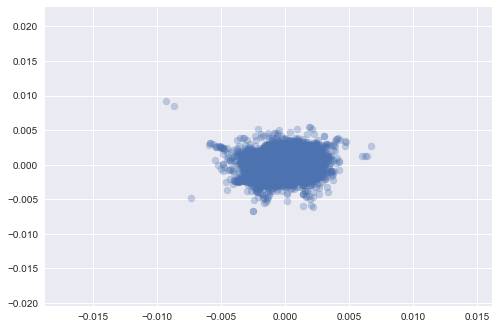

In [67]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha = .3)
plt.show()

Okay, so that took a long time and didn't really provide much information. Let's try again with it turned up to 11.

In [60]:
X_tsne2 = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300).fit_transform(tops)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10782
[t-SNE] Computed conditional probabilities for sample 2000 / 10782
[t-SNE] Computed conditional probabilities for sample 3000 / 10782
[t-SNE] Computed conditional probabilities for sample 4000 / 10782
[t-SNE] Computed conditional probabilities for sample 5000 / 10782
[t-SNE] Computed conditional probabilities for sample 6000 / 10782
[t-SNE] Computed conditional probabilities for sample 7000 / 10782
[t-SNE] Computed conditional probabilities for sample 8000 / 10782
[t-SNE] Computed conditional probabilities for sample 9000 / 10782
[t-SNE] Computed conditional probabilities for sample 10000 / 10782
[t-SNE] Computed conditional probabilities for sample 10782 / 10782
[t-SNE] Mean sigma: 13.027158
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.124671
[t-SNE] Error after 300 iterations: 1.124671


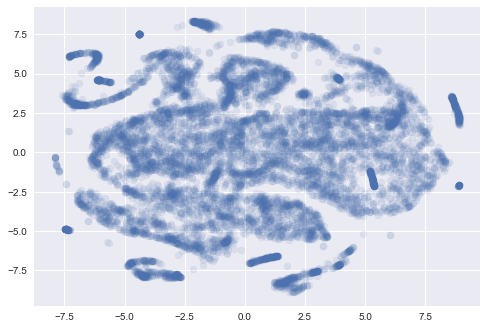

In [64]:
plt.scatter(X_tsne2[:, 0], X_tsne2[:, 1], alpha = .1)
plt.show()

Getting some more separation but not seeing anywhere near clearly defined clusters. I'll try letting it run overnight with steps set to 5,000 and see if that reveals anything.

Any tuning suggestions you have for t-SNE parameters or modifications to df I'm feeding it would be greatly appreciated.

Also, would you suggest sampling a smaller portion of the df to run t-sne on? `tops` df I'm using above has about 10k obs and 55 features.